In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
path = '/content/drive/Shareddrives/엘포인트 홧팅/데이터/'

demo = pd.read_csv(path+'LPOINT_BIG_COMP_01_DEMO.csv')
pdde = pd.read_csv(path+'LPOINT_BIG_COMP_02_PDDE.csv')
copu = pd.read_csv(path+'LPOINT_BIG_COMP_03_COP_U.csv')
pdclac = pd.read_csv(path+'LPOINT_BIG_COMP_04_PD_CLAC.csv')
br = pd.read_csv(path+'LPOINT_BIG_COMP_05_BR.csv')
lpay = pd.read_csv(path+'LPOINT_BIG_COMP_06_LPAY.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
temp = pd.concat([pdde,copu])
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN


In [ ]:
print(temp.shape, demo.shape)

(4630047, 11) (29913, 4)


In [ ]:
# 구매 이력이 하루만 있는 고객 제외 : 하루에 2번 이상 구매해도 하루만 구매한 거로 간주.
cus_count = temp[['cust', 'de_dt']].drop_duplicates().groupby('cust', as_index=False)['de_dt'].count()
cus_count.head()

,cust,de_dt
0,M000034966,8
1,M000059535,1
2,M000136117,44
3,M000201112,4
4,M000225114,43


In [ ]:
cust_over2 = cus_count.loc[cus_count.de_dt>=2, "cust"].to_list() # 구매를 이틀 이상 한 고객 리스트
temp = temp[temp.cust.isin(cust_over2)]
demo = demo[demo.cust.isin(cust_over2)]
print(temp.shape, demo.shape)

(4624997, 11) (27553, 4)


In [ ]:
# # 한글 깨짐 방지
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plt.rc('font', family='NanumBarunGothic')

# Target

In [ ]:
# 날짜 + 시간 합치기 : hour까지 나와있으므로 임의로 minute는 00으로 설정
temp['hm'] = temp.de_hr.apply(lambda x : str(x)+':00')

In [ ]:
temp['time'] = temp.de_dt.map(str)+' '+temp.hm.map(str)

In [ ]:
# datetime type으로 변경
temp['time'] = pd.to_datetime(temp['time'], format="%Y%m%d %H:%M")
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00


### LPL (Last Purchasing Lapse) : 최종구매경과

In [ ]:
# LPL (Last Purchasing Lapse) : 최종구매경과. 관찰기간 내에서 현재를 기준일로 설정하였을 때 최종 구매 시점부터 현재 기준일까지 경과한 기간
from datetime import datetime
from datetime import timedelta

now = datetime(2022, 1, 1) # 현재 (기준일) : 2022-01-01 00:00:00
LPL = temp.groupby('cust', as_index=False)['time'].apply(lambda x : (now-x.max()).total_seconds()/(3600*24)) # 시간으로 계산하고 날짜로 변환 >> 단위는 날짜이되 소숫점까지 나올 수 있게
print(LPL.shape, LPL.isnull().sum().sum())

(27553, 2) 0


In [ ]:
LPL.head()

,cust,time
0,M000034966,8.208333
1,M000136117,1.166667
2,M000201112,33.333333
3,M000225114,0.208333
4,M000261625,27.458333


In [ ]:
demo = pd.merge(demo, LPL)
demo.rename(columns = {'time':'LPL'}, inplace=True)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,LPL
0,M000034966,여성,40대,Z07,8.208333
1,M000136117,여성,30대,Z11,1.166667
2,M000201112,여성,50대,Z17,33.333333
3,M000225114,여성,40대,Z17,0.208333
4,M000261625,여성,40대,Z17,27.458333


In [ ]:
demo.isnull().sum()

cust         0
ma_fem_dv    0
ages         0
zon_hlv      0
LPL          0
dtype: int64

### MPI(Maximim Purchasing Interval)

In [ ]:
buy_sort = temp[['cust', 'time']].drop_duplicates().sort_values(by=['cust', 'time'], ascending=True)
buy_sort.head()

,cust,time
24061,M000034966,2021-01-16 18:00:00
3990606,M000034966,2021-01-16 21:00:00
1355775,M000034966,2021-03-25 13:00:00
1377569,M000034966,2021-03-28 21:00:00
2021903,M000034966,2021-06-29 13:00:00


In [ ]:
buy_diff = temp[['cust', 'time']].drop_duplicates().sort_values(by=['cust', 'time'], ascending=True).groupby('cust', as_index=False)['time'].diff()
buy_diff.head()

,time
24061,NaT
3990606,0 days 03:00:00
1355775,67 days 16:00:00
1377569,3 days 08:00:00
2021903,92 days 16:00:00


In [ ]:
buy_diff['time'] = buy_diff.time.dt.total_seconds()/(3600*24)
buy_diff.head()

,time
24061,NaN
3990606,0.125000
1355775,67.666667
1377569,3.333333
2021903,92.666667


In [ ]:
PI = pd.concat([buy_sort, buy_diff], axis=1)
PI.columns = ['cust', 'ymd', 'PI']
PI.head()

,cust,ymd,PI
24061,M000034966,2021-01-16 18:00:00,NaN
3990606,M000034966,2021-01-16 21:00:00,0.125000
1355775,M000034966,2021-03-25 13:00:00,67.666667
1377569,M000034966,2021-03-28 21:00:00,3.333333
2021903,M000034966,2021-06-29 13:00:00,92.666667


In [ ]:
MPI = PI.groupby('cust', as_index=False)['PI'].max()
print(MPI.shape, MPI.isnull().sum().sum())

(27553, 2) 0


In [ ]:
demo = pd.merge(demo, MPI)
demo.rename(columns = {'PI':'MPI'}, inplace=True)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,LPL,MPI
0,M000034966,여성,40대,Z07,8.208333,92.666667
1,M000136117,여성,30대,Z11,1.166667,34.000000
2,M000201112,여성,50대,Z17,33.333333,107.500000
3,M000225114,여성,40대,Z17,0.208333,34.958333
4,M000261625,여성,40대,Z17,27.458333,41.791667


In [ ]:
demo.isnull().sum()

cust         0
ma_fem_dv    0
ages         0
zon_hlv      0
LPL          0
MPI          0
dtype: int64

### Target

LPL>MPI 이면 이탈로 간주

In [ ]:
import numpy as np
demo['target'] = np.where(demo.LPL>demo.MPI, 1, 0)

In [ ]:
demo.target.value_counts()

0    23715
1     3838
Name: target, dtype: int64

이탈하지 않은 고객이 이탈한 고객의 약 6배

In [ ]:
demo.drop(['MPI', 'LPL'], axis=1, inplace=True)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target
0,M000034966,여성,40대,Z07,0
1,M000136117,여성,30대,Z11,0
2,M000201112,여성,50대,Z17,0
3,M000225114,여성,40대,Z17,0
4,M000261625,여성,40대,Z17,0


# 구매 금액의 표준편차

In [ ]:
buy_std = temp.groupby('cust', as_index=False)['buy_am'].std()
demo['buy_std'] = pd.merge(demo, buy_std, on='cust')['buy_am']
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target,buy_std
0,M000034966,여성,40대,Z07,0,16571.446308
1,M000136117,여성,30대,Z11,0,433479.199112
2,M000201112,여성,50대,Z17,0,2121.612750
3,M000225114,여성,40대,Z17,0,21457.501705
4,M000261625,여성,40대,Z17,0,157065.019200


# 대대분류에 따른 제품 선호도

|표기|대대분류|대분류|
|:---:|:---:|:---:|
|Fashion|패션의류|패션잡화, 여성의류, 남성의류|
|Health|스포츠/레저/건강|아웃도어/레저, 건강식품, 구기/필드스포츠|
|Beauty|화장품/뷰티|화장품/뷰티케어, 퍼스널케어|
|Food|식품|채소, 과일, F&B(제휴사)|
|Baby|유아동|유아동의류, 출산/육아용품, 유아식품|
|Home|주방/생활/가구/인테리어/렌탈|식기/조리기구, 청소/세탁/욕실용품, 인테리어/조명, 렌탈(제휴사) 등|
|Electronic|가전/디지털|생활/주방가전, 영상/음향가전 등|
|Pet|반려동물|원예/애완|
|Travel|여행|여행/레저서비스, 숙박(제휴사)|
|Culture|엔터테인먼트|서적/음악/악기, 엔터테인먼트(제휴사)|
|Etc|기타|금융, 상품권 등|

In [ ]:
clac_nm = pd.read_excel(path+"대분류.xlsx", engine="openpyxl")
clac_nm.head()

,index,clac_hlv_nm,대대분류
0,패션잡화,130.0,Fashion
1,축산물,91.0,Food
2,수산물,88.0,Food
3,스포츠패션,82.0,Health
4,문구/사무용품,72.0,Home


In [ ]:
ttt = pd.merge(pdclac, clac_nm[['index', '대대분류']], how='left', left_on='clac_hlv_nm', right_on='index')
ttt.head()

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm,index,대대분류
0,PD0001,소파,가구,거실가구,가구,Home
1,PD0002,스툴/리빙의자,가구,거실가구,가구,Home
2,PD0003,탁자,가구,거실가구,가구,Home
3,PD0004,장식장/진열장,가구,거실가구,가구,Home
4,PD0005,기타가구,가구,기타가구,가구,Home


In [ ]:
cust_pdc = pd.merge(temp, ttt[['pd_c', '대대분류']], how='left', on='pd_c')
cust_pdc.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,대대분류
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,Fashion
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,Home
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,Fashion
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,Fashion
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,Fashion


In [ ]:
cust_pdc.loc[cust_pdc.cop_c.str.contains('B'), "대대분류"] = "Travel"
cust_pdc.loc[cust_pdc.cop_c.str.contains('C'), "대대분류"] = "Culture"
cust_pdc.loc[cust_pdc.cop_c.str.contains('D'), "대대분류"] = "Food"
cust_pdc.loc[cust_pdc.cop_c.str.contains('E'), "대대분류"] = "Home"

제휴사의 경우 상품명이 나와있지 않으므로 제휴사 업종명으로 대체

In [ ]:
cust_pdc.대대분류.isnull().sum()

0

In [ ]:
temp_pd = pd.get_dummies(cust_pdc, columns=["대대분류"])
temp_pd.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,대대분류_Pet,대대분류_Travel
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,...,0,0,0,0,1,0,0,0,0,0
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,...,0,0,0,0,0,0,0,1,0,0
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,...,0,0,0,0,1,0,0,0,0,0
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,...,0,0,0,0,1,0,0,0,0,0
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
cust_pd = temp_pd.groupby('cust', as_index=False)[temp_pd.columns[temp_pd.columns.str.contains('대대분류')]].mean() 
cust_pd.head()

,cust,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,대대분류_Pet,대대분류_Travel
0,M000034966,0.038462,0.000000,0.000000,0.000000,0.000000,0.173077,0.673077,0.076923,0.019231,0.019231,0.0
1,M000136117,0.016129,0.040323,0.000000,0.016129,0.000000,0.419355,0.258065,0.064516,0.185484,0.000000,0.0
2,M000201112,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.904762,0.000000,0.047619,0.000000,0.0
3,M000225114,0.005917,0.041420,0.047337,0.000000,0.000000,0.053254,0.828402,0.023669,0.000000,0.000000,0.0
4,M000261625,0.000000,0.500000,0.000000,0.029412,0.000000,0.102941,0.338235,0.014706,0.014706,0.000000,0.0


In [ ]:
demo = pd.merge(demo, cust_pd)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,대대분류_Pet,대대분류_Travel
0,M000034966,여성,40대,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,0.000000,0.173077,0.673077,0.076923,0.019231,0.019231,0.0
1,M000136117,여성,30대,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,0.000000,0.419355,0.258065,0.064516,0.185484,0.000000,0.0
2,M000201112,여성,50대,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.904762,0.000000,0.047619,0.000000,0.0
3,M000225114,여성,40대,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,0.000000,0.053254,0.828402,0.023669,0.000000,0.000000,0.0
4,M000261625,여성,40대,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,0.000000,0.102941,0.338235,0.014706,0.014706,0.000000,0.0


# 공휴일

In [ ]:
# de_dt를 datetime type으로 변경
temp['ymd'] = pd.to_datetime(temp['de_dt'], format="%Y%m%d")
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,ymd
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01


In [ ]:
!pip install pykrx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 주식 개장일로 공휴일이 아닌 날 불러오기 : 12/31일은 폐장일임을 유의
from pykrx import stock
weekday = stock.get_market_ohlcv("20201227", "20211231", "005930").reset_index(drop=False)['날짜'].astype(str).to_list()

In [ ]:
len(temp.loc[~temp.ymd.isin(weekday), "ymd"].astype(str).unique()) # RedDay는 총 116일 >> 20/12/27(RedDay에는 20년도 휴일이 반영되어있지 않음),31이랑 21/12/31(주식 휴장일이지만 평일) 더하면 119일 맞음!

119

In [ ]:
RedDay = list(temp.loc[~temp.ymd.isin(weekday), "ymd"].astype(str).unique())
RedDay.remove('2020-12-31')
RedDay.remove('2021-12-31')

In [ ]:
temp['RedDay'] = temp['ymd'].astype(str).apply(lambda x : 1 if x in RedDay else 0)
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,ymd,RedDay
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1


In [ ]:
RedDay_ratio = temp.groupby('cust', as_index=False)['RedDay'].mean() 
RedDay_ratio.head() 

,cust,RedDay
0,M000034966,0.692308
1,M000136117,0.306452
2,M000201112,0.571429
3,M000225114,0.230769
4,M000261625,0.544118


In [ ]:
demo = pd.merge(demo, RedDay_ratio)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,대대분류_Pet,대대분류_Travel,RedDay
0,M000034966,여성,40대,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,0.000000,0.173077,0.673077,0.076923,0.019231,0.019231,0.0,0.692308
1,M000136117,여성,30대,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,0.000000,0.419355,0.258065,0.064516,0.185484,0.000000,0.0,0.306452
2,M000201112,여성,50대,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.904762,0.000000,0.047619,0.000000,0.0,0.571429
3,M000225114,여성,40대,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,0.000000,0.053254,0.828402,0.023669,0.000000,0.000000,0.0,0.230769
4,M000261625,여성,40대,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,0.000000,0.102941,0.338235,0.014706,0.014706,0.000000,0.0,0.544118


# Time Division

Time Division : 각 구매 시간대의 비율


*   2-6 : Daybreak
*   7-11 : Morning
*   12-15 : Midday
*   16-20 : Twilight
*   21-1 : Midnight

In [ ]:
b = [0, 2, 7, 12, 16, 21, 24]
l = ['Midnight', 'Daybreak', 'Morning', 'Midday', 'Twilight', 'Middnight']
temp['TD'] = pd.cut(temp.de_hr, bins=b, labels=l, right=False)
temp.loc[temp.TD=="Middnight", "TD"] = 'Midnight'
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,ymd,RedDay,TD
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning


In [ ]:
temp.TD.value_counts()

Twilight     2138625
Midday       1500129
Morning       540325
Midnight      420257
Daybreak       25661
Middnight          0
Name: TD, dtype: int64

In [ ]:
temp_td = pd.get_dummies(temp, columns=["TD"])
temp_td.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,hm,time,ymd,RedDay,TD_Midnight,TD_Daybreak,TD_Morning,TD_Midday,TD_Twilight,TD_Middnight
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,...,10:00,2021-01-01 10:00:00,2021-01-01,1,0,0,1,0,0,0
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,...,10:00,2021-01-01 10:00:00,2021-01-01,1,0,0,1,0,0,0
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,...,10:00,2021-01-01 10:00:00,2021-01-01,1,0,0,1,0,0,0
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,...,10:00,2021-01-01 10:00:00,2021-01-01,1,0,0,1,0,0,0
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,...,10:00,2021-01-01 10:00:00,2021-01-01,1,0,0,1,0,0,0


In [ ]:
temp_td.columns

Index(['cust', 'rct_no', 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_dt', 'de_hr',
       'buy_am', 'buy_ct', 'vst_dt', 'hm', 'time', 'ymd', 'RedDay',
       'TD_Midnight', 'TD_Daybreak', 'TD_Morning', 'TD_Midday', 'TD_Twilight',
       'TD_Middnight'],
      dtype='object')

In [ ]:
temp_td.drop('TD_Middnight', axis=1, inplace=True)

In [ ]:
cust_td = temp_td.groupby('cust', as_index=False)[temp_td.columns[temp_td.columns.str.contains('TD')]].mean() 
cust_td.head()

,cust,TD_Midnight,TD_Daybreak,TD_Morning,TD_Midday,TD_Twilight
0,M000034966,0.096154,0.0,0.019231,0.153846,0.730769
1,M000136117,0.040323,0.0,0.096774,0.387097,0.475806
2,M000201112,0.428571,0.0,0.000000,0.523810,0.047619
3,M000225114,0.000000,0.0,0.047337,0.112426,0.840237
4,M000261625,0.000000,0.0,0.044118,0.441176,0.514706


In [ ]:
demo = pd.merge(demo, cust_td)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,...,대대분류_Health,대대분류_Home,대대분류_Pet,대대분류_Travel,RedDay,TD_Midnight,TD_Daybreak,TD_Morning,TD_Midday,TD_Twilight
0,M000034966,여성,40대,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,...,0.076923,0.019231,0.019231,0.0,0.692308,0.096154,0.0,0.019231,0.153846,0.730769
1,M000136117,여성,30대,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,...,0.064516,0.185484,0.000000,0.0,0.306452,0.040323,0.0,0.096774,0.387097,0.475806
2,M000201112,여성,50대,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.047619,0.000000,0.0,0.571429,0.428571,0.0,0.000000,0.523810,0.047619
3,M000225114,여성,40대,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,...,0.023669,0.000000,0.000000,0.0,0.230769,0.000000,0.0,0.047337,0.112426,0.840237
4,M000261625,여성,40대,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,...,0.014706,0.014706,0.000000,0.0,0.544118,0.000000,0.0,0.044118,0.441176,0.514706


In [ ]:
demo.isnull().sum()

cust               0
ma_fem_dv          0
ages               0
zon_hlv            0
target             0
buy_std            0
대대분류_Baby          0
대대분류_Beauty        0
대대분류_Culture       0
대대분류_Electronic    0
대대분류_Etc           0
대대분류_Fashion       0
대대분류_Food          0
대대분류_Health        0
대대분류_Home          0
대대분류_Pet           0
대대분류_Travel        0
RedDay             0
TD_Midnight        0
TD_Daybreak        0
TD_Morning         0
TD_Midday          0
TD_Twilight        0
dtype: int64

# L.Point 구매 여부

In [ ]:
lpay_cust=lpay.cust.unique()

In [ ]:
demo['lpay']=demo['cust'].apply(lambda x : 1 if x in lpay_cust else 0)
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,...,대대분류_Home,대대분류_Pet,대대분류_Travel,RedDay,TD_Midnight,TD_Daybreak,TD_Morning,TD_Midday,TD_Twilight,lpay
0,M000034966,여성,40대,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,...,0.019231,0.019231,0.0,0.692308,0.096154,0.0,0.019231,0.153846,0.730769,0
1,M000136117,여성,30대,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,...,0.185484,0.000000,0.0,0.306452,0.040323,0.0,0.096774,0.387097,0.475806,1
2,M000201112,여성,50대,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,...,0.047619,0.000000,0.0,0.571429,0.428571,0.0,0.000000,0.523810,0.047619,0
3,M000225114,여성,40대,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,...,0.000000,0.000000,0.0,0.230769,0.000000,0.0,0.047337,0.112426,0.840237,0
4,M000261625,여성,40대,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,...,0.014706,0.000000,0.0,0.544118,0.000000,0.0,0.044118,0.441176,0.514706,0


# R, F, M

In [ ]:
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,ymd,RedDay,TD
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning


In [ ]:
from datetime import datetime
last = datetime(2022, 1, 1)
rfm = temp.groupby('cust', as_index=False).agg({
    'time' : lambda x : (last-x.max()).total_seconds()/3600, # recency : hours 단위 차이
    'rct_no' : 'count', # frequency
    'buy_am' : 'sum' # monetary
})

In [ ]:
rfm.head()

,cust,time,rct_no,buy_am
0,M000034966,197.0,52,658020.0
1,M000136117,28.0,124,27611030.0
2,M000201112,800.0,21,53120.0
3,M000225114,5.0,169,2253900.0
4,M000261625,659.0,68,6075950.0


In [ ]:
rfm.rename(columns = {'time':'Recency', 'rct_no':'Frequency', 'buy_am':'Monetary'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

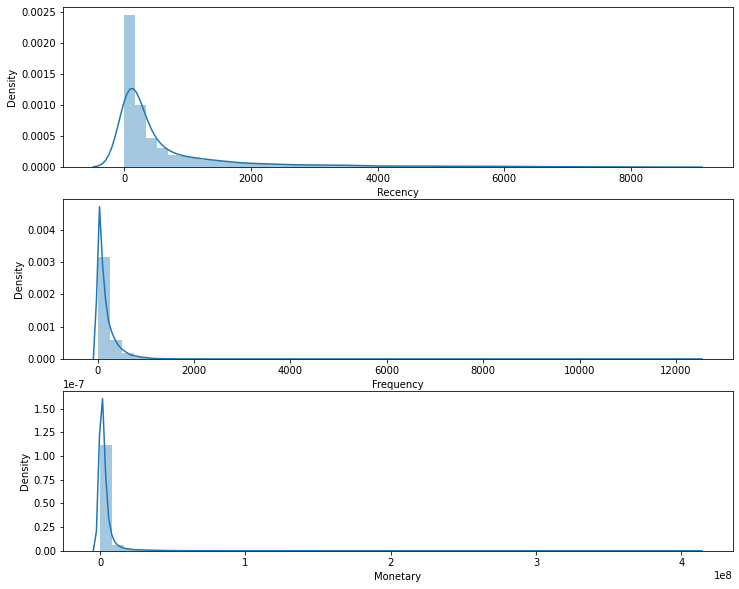

In [ ]:
# Plotting RFM distributions
plt.figure(figsize=(12,10))

# Plot distribution of R
plt.subplot(3, 1, 1)
sns.distplot(rfm['Recency'])

# Plot distribution of F
plt.subplot(3, 1, 2)
sns.distplot(rfm['Frequency'])

# Plot distribution of M
plt.subplot(3, 1, 3)
sns.distplot(rfm['Monetary'])

plt.show()

일반적으로 이상치(outlier)는 정상값 분석에 안 좋은 영향을 미치기 때문에 정규화 등을 통해 제거하지만 소수의 이상치가 의미 있게 분석되는 경우도 있으며 특히 고객 세분
화의 경우에는 VVIP, VVVIP 등을 구분할 때도 활용될 수 있기 때문에 본 분석에서는 이상치 제거 단계를 거치지 않았다.

In [ ]:
r_labels = range(5, 0, -1) # 작을수록 좋음
fm_labels = range(1, 6) # 클수록 좋음

r_groups = pd.qcut(rfm['Recency'], q=5, labels=r_labels)
f_groups = pd.qcut(rfm['Frequency'], q=5, labels=fm_labels)
m_groups = pd.qcut(rfm['Monetary'], q=5, labels=fm_labels)

rfm = rfm.assign(R = r_groups.values, F = f_groups.values, M = m_groups.values)
rfm.head()

,cust,Recency,Frequency,Monetary,R,F,M
0,M000034966,197.0,52,658020.0,3,2,2
1,M000136117,28.0,124,27611030.0,5,3,5
2,M000201112,800.0,21,53120.0,2,1,1
3,M000225114,5.0,169,2253900.0,5,4,4
4,M000261625,659.0,68,6075950.0,2,3,5


**R score**

|R score|Hours before|count|Ratio(%)|Acc. ratio(%)|
|:---:|:---:|:---:|:---:|:---:|
|5|0-53|5543|20.1%|20.1%|
|4|54-155|5580|20.2%|40.3%|
|3|156-364|5419|19.7%|60.0%|
|2|365-1110|5509|20.0%|80.0%|
|1|1111-8635|5502|20.0%|100%|

In [ ]:
pd.qcut(rfm['Recency'], q=5, labels=r_labels, retbins=True)

(0        3
 1        5
 2        2
 3        5
 4        2
         ..
 27548    1
 27549    5
 27550    2
 27551    2
 27552    5
 Name: Recency, Length: 27553, dtype: category
 Categories (5, int64): [5 < 4 < 3 < 2 < 1],
 array([1.000e+00, 5.300e+01, 1.550e+02, 3.640e+02, 1.110e+03, 8.635e+03]))

In [ ]:
rfm.R.value_counts().sort_index()

5    5543
4    5580
3    5419
2    5509
1    5502
Name: R, dtype: int64

In [ ]:
rfm.R.value_counts(normalize=True).sort_index()

5    0.201176
4    0.202519
3    0.196675
2    0.199942
1    0.199688
Name: R, dtype: float64

**F score**

|F score|rct_no count|Counts|Ratio(%)|Acc. ratio(%)|
|:---:|:---:|:---:|:---:|:---:|
|5|270-12453|5520|20.0%|20.0%|
|4|133-269|5612|20.4%|40.4%|
|3|66-132|5437|19.7%|60.1%|
|2|22-65|5475|19.9%|80.0%|
|1|2-21|5509|20.0%|100%|

In [ ]:
pd.qcut(rfm['Frequency'], q=5, labels=fm_labels, retbins=True)

(0        2
 1        3
 2        1
 3        4
 4        3
         ..
 27548    1
 27549    5
 27550    3
 27551    1
 27552    5
 Name: Frequency, Length: 27553, dtype: category
 Categories (5, int64): [1 < 2 < 3 < 4 < 5],
 array([2.0000e+00, 2.1000e+01, 6.5000e+01, 1.3200e+02, 2.6900e+02,
        1.2453e+04]))

In [ ]:
rfm.F.value_counts().sort_index()

1    5520
2    5612
3    5437
4    5475
5    5509
Name: F, dtype: int64

In [ ]:
rfm.F.value_counts(normalize=True).sort_index()

1    0.200341
2    0.203680
3    0.197329
4    0.198708
5    0.199942
Name: F, dtype: float64

**M score**

|F score|Money|Counts|Ratio(%)|Acc. ratio(%)|
|:---:|:---:|:---:|:---:|:---:|
|5|4282048.9-409821075|5511|20.0%|20.0%|
|4|2039131.9-4282048.8|5510|20.0%|40.0%|
|3|1028695.7-2039131.8|5511|20.0%|60.0%|
|2|345477-1028695.6|5510|20.0%|80.0%|
|1|2800-345476|5511|20.0%|100%|

In [ ]:
pd.qcut(rfm['Monetary'], q=5, labels=fm_labels, retbins=True)

(0        2
 1        5
 2        1
 3        4
 4        5
         ..
 27548    1
 27549    3
 27550    3
 27551    1
 27552    5
 Name: Monetary, Length: 27553, dtype: category
 Categories (5, int64): [1 < 2 < 3 < 4 < 5],
 array([2.80000000e+03, 3.45476000e+05, 1.02869560e+06, 2.03913180e+06,
        4.28204880e+06, 4.09821075e+08]))

In [ ]:
rfm.M.value_counts().sort_index()

1    5511
2    5510
3    5511
4    5510
5    5511
Name: M, dtype: int64

In [ ]:
rfm.M.value_counts(normalize=True).sort_index()

1    0.200015
2    0.199978
3    0.200015
4    0.199978
5    0.200015
Name: M, dtype: float64

In [ ]:
demo = pd.merge(demo, rfm)

In [ ]:
demo.head()

,cust,ma_fem_dv,ages,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,...,TD_Morning,TD_Midday,TD_Twilight,lpay,Recency,Frequency,Monetary,R,F,M
0,M000034966,여성,40대,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,...,0.019231,0.153846,0.730769,0,197.0,52,658020.0,3,2,2
1,M000136117,여성,30대,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,...,0.096774,0.387097,0.475806,1,28.0,124,27611030.0,5,3,5
2,M000201112,여성,50대,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.523810,0.047619,0,800.0,21,53120.0,2,1,1
3,M000225114,여성,40대,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,...,0.047337,0.112426,0.840237,0,5.0,169,2253900.0,5,4,4
4,M000261625,여성,40대,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,...,0.044118,0.441176,0.514706,0,659.0,68,6075950.0,2,3,5


# 성별, 나이

In [ ]:
demo.ages.value_counts().sort_index()

20대    3329
30대    7177
40대    9367
50대    5196
60대    1865
70대     619
Name: ages, dtype: int64

In [ ]:
demo.ages.replace(to_replace=['60대', '70대'], value='60대 이상', inplace=True)

In [ ]:
demo = pd.get_dummies(demo, columns=["ma_fem_dv", "ages"])
demo.head()

,cust,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,...,R,F,M,ma_fem_dv_남성,ma_fem_dv_여성,ages_20대,ages_30대,ages_40대,ages_50대,ages_60대 이상
0,M000034966,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,0.000000,0.173077,...,3,2,2,0,1,0,0,1,0,0
1,M000136117,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,0.000000,0.419355,...,5,3,5,0,1,0,1,0,0,0
2,M000201112,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,...,2,1,1,0,1,0,0,0,1,0
3,M000225114,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,0.000000,0.053254,...,5,4,4,0,1,0,0,1,0,0
4,M000261625,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,0.000000,0.102941,...,2,3,5,0,1,0,0,1,0,0


In [ ]:
demo.to_csv(path+"전처리7/demo_before_split.csv")

# 뉴스심리지수

In [ ]:
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,ymd,RedDay,TD
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning


In [ ]:
NSI_con = temp[['cust', 'ymd','buy_am']]
NSI_con.head()

,cust,ymd,buy_am
0,M430112881,2021-01-01,15000.0
1,M646853852,2021-01-01,79700.0
2,M430112881,2021-01-01,19000.0
3,M430112881,2021-01-01,19000.0
4,M430112881,2021-01-01,19000.0


In [ ]:
NSI_con.shape

(4624997, 3)

In [ ]:
# 고객 일별 구매횟수 카운트
NSI_con = pd.DataFrame(NSI_con.groupby(['cust', 'ymd'], as_index=False)['buy_am'].count())

In [ ]:
NSI_con.rename(columns={'buy_am':'buy_count'},inplace=True)
NSI_con.head()

,cust,ymd,buy_count
0,M000034966,2021-01-16,6
1,M000034966,2021-03-25,6
2,M000034966,2021-03-28,3
3,M000034966,2021-06-29,1
4,M000034966,2021-08-29,1


In [ ]:
NSI_con.shape

(1020296, 3)

뉴스심리지수 데이터프레임 생성

In [ ]:
NSI_data=pd.read_csv('/content/drive/Shareddrives/엘포인트 홧팅/데이터/NSI.csv')

In [ ]:
NSI_data=NSI_data.drop(['통계표','계정항목','단위','변환'], axis=1)

import numpy as np

NSI_data=np.transpose(NSI_data)
NSI_data.head()

,0
2020/12/28,109.70
2020/12/29,109.54
2020/12/30,110.38
2020/12/31,108.58
2021/01/04,112.84


In [ ]:
NSI_data=NSI_data.reset_index()
NSI_data.rename(columns={"index":"ymd",0:"뉴스심리지수"},inplace=True)

In [ ]:
# 날짜형으로 변환 
NSI_data["ymd"]=pd.to_datetime(NSI_data["ymd"])
NSI_data.head()

,ymd,뉴스심리지수
0,2020-12-28,109.70
1,2020-12-29,109.54
2,2020-12-30,110.38
3,2020-12-31,108.58
4,2021-01-04,112.84


결측치 대체 

뉴스심리지수는 평일의 값만 제공한다. 또한 뉴스심리지수 데이터를 가져올 때 2021년 1년치의 데이터만 갖고왔으므로 두 종류의 결측치가 존재한다. 결측치는 다음과 같은 방식으로 처리하였다.

* 12월 27일 뉴스심리지수는 12월 24일 뉴스심리지수 값으로 대체 (12월 27일 : 주말)

* 이외의 결측치는 'ffill'을 사용하여 바로 위 값과 동일하게 변경함. (주말에 해당)

In [ ]:
# temp 데이터의 날짜 구간 확인하기 
temp_data_date = NSI_con[['ymd']]
temp_data_date = temp_data_date.sort_values(by="ymd",ascending=True)
temp_data_date = temp_data_date.drop_duplicates()

temp_data_date.head()

,ymd
510749,2020-12-27
199075,2020-12-29
885618,2020-12-30
475160,2020-12-31
401862,2021-01-01


* temp의 날짜 : 2020년 12월 27 - 2021년 12월 31일

In [ ]:
NSI_data_final=pd.merge(temp_data_date,NSI_data,how='left',on='ymd')

In [ ]:
NSI_data_final=NSI_data_final.fillna(method='ffill')

In [ ]:
# 12월 27일 뉴스심리지수는 12월 24일 뉴스심리지수 값으로 대체
NSI_data_final.loc[0,'뉴스심리지수']=110.79

In [ ]:
NSI_data_final.head()

,ymd,뉴스심리지수
0,2020-12-27,110.79
1,2020-12-29,109.54
2,2020-12-30,110.38
3,2020-12-31,108.58
4,2021-01-01,108.58


In [ ]:
NSI_data_final['뉴스심리지수'].isnull().sum()

0

In [ ]:
NSI_cust=pd.merge(NSI_con,NSI_data_final,how='left')
NSI_cust=NSI_cust.sort_values(by='cust',ascending=True)
NSI_cust.head()

,cust,ymd,buy_count,뉴스심리지수
0,M000034966,2021-01-16,6,114.17
1,M000034966,2021-03-25,6,112.76
2,M000034966,2021-03-28,3,112.71
3,M000034966,2021-06-29,1,116.10
4,M000034966,2021-08-29,1,102.21


* 100 초과 : 경제심리가 과거 대비 낙관적 

* 100 미만 : 경제심리가 과거 대비 비관적

In [ ]:
from sklearn.linear_model import LinearRegression
cust_id_NSI = []
cust_beta_NSI = []
cust_r2_NSI = []

cust_uniq = NSI_cust.cust.unique()
for i in cust_uniq:
  cust_temp = NSI_cust[NSI_cust.cust==i]
  if cust_temp.shape[0]>=3: # 같은 날짜일 경우 구매 금액을 합쳤기 때문에 shape[0]==1일 수 있음 / shape[0]이 2면 R^2가 1이어서 의미가 없음. 3부터 시작. 나머지는 KNN으로 채우기

    cust_buy_count = sum(cust_temp.buy_count)
    X = cust_temp.뉴스심리지수.values.reshape(-1, 1)
    y = cust_temp.buy_count.values.reshape(-1, 1)/cust_buy_count*100

    # if all(j<80 for j in y):
    model = LinearRegression()
    model.fit(X, y)
      
    cust_id_NSI.append(i)
    cust_beta_NSI.append(abs(float(model.coef_))) # beta 절댓값으로 빼서 민감도 보기
    cust_r2_NSI.append(model.score(X, y))

In [ ]:
import numpy as np
np.mean(cust_r2_NSI)

0.10734736945292406

In [ ]:
np.mean(cust_beta_NSI)

0.3564116744483795

In [ ]:
pd.Series(cust_beta_NSI).describe()

count    26394.000000
mean         0.356412
std          1.834859
min          0.000000
25%          0.014472
50%          0.053281
75%          0.187342
max        109.976434
dtype: float64

In [ ]:
100*pd.Series(cust_beta_NSI).describe()

count    2.639400e+06
mean     3.564117e+01
std      1.834859e+02
min      0.000000e+00
25%      1.447238e+00
50%      5.328063e+00
75%      1.873416e+01
max      1.099764e+04
dtype: float64

In [ ]:
pd.Series(cust_r2_NSI).describe()

count    26394.000000
mean         0.107347
std          0.227563
min          0.000000
25%          0.003777
50%          0.019974
75%          0.078406
max          1.000000
dtype: float64

In [ ]:
cust_id_NSI = pd.DataFrame(cust_id_NSI)
cust_beta_NSI = 100*pd.DataFrame(cust_beta_NSI) # scaling

In [ ]:
Trend_NSI = pd.concat([cust_id_NSI,cust_beta_NSI],axis=1)
Trend_NSI.columns = ['cust','NSI_beta']

In [ ]:
Trend_NSI.head()

,cust,NSI_beta
0,M000034966,71.889923
1,M000136117,12.116240
2,M000201112,901.912902
3,M000225114,2.989647
4,M000261625,8.413015


In [ ]:
# beta 이상치 삭제 > 데이터 개수가 3 또는 4인 경우 대부분의 데이터가 한 곳에 몰려있으면 r^2가 지나치게 높게 나오고 베타가 커지는 경향. 제대로 계산되지 않았으므로 이상치라고 판단하여 제거 후 KNN 진행 예정
Q1 = np.percentile(Trend_NSI.NSI_beta, 25)
Q3 = np.percentile(Trend_NSI.NSI_beta, 75)
IQR = Q3 - Q1
outlier_lower = Q1 - 1.5*IQR
outlier_upper = Q3 + 1.5*IQR

print(outlier_lower, outlier_upper)

-24.48314991218865 44.66455206165733


In [ ]:
# 값 자체를 새로 만들었으므로 계산 과정에서 오류가 있을 가능성 염두. IQR 이상치 방식으로 outlier 제거 > 이후 KNN으로 채우기
Trend_NSI = Trend_NSI[(Trend_NSI.NSI_beta>outlier_lower) & (Trend_NSI.NSI_beta<outlier_upper)]

In [ ]:
Trend_NSI.shape

(22887, 2)

In [ ]:
Trend_NSI.to_csv(path+'Trend_NSI.csv', index=False)

In [ ]:
NSI = pd.read_csv(path+"Trend_NSI.csv")
NSI.head()

,cust,NSI_beta
0,M000136117,12.116240
1,M000225114,2.989647
2,M000261625,8.413015
3,M000350564,10.210513
4,M000419293,9.664995


In [ ]:
demo = pd.merge(demo, NSI, how="left")
demo.head()

,cust,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,...,F,M,ma_fem_dv_남성,ma_fem_dv_여성,ages_20대,ages_30대,ages_40대,ages_50대,ages_60대 이상,NSI_beta
0,M000034966,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,0.000000,0.173077,...,2,2,0,1,0,0,1,0,0,NaN
1,M000136117,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,0.000000,0.419355,...,3,5,0,1,0,1,0,0,0,12.116240
2,M000201112,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,...,1,1,0,1,0,0,0,1,0,NaN
3,M000225114,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,0.000000,0.053254,...,4,4,0,1,0,0,1,0,0,2.989647
4,M000261625,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,0.000000,0.102941,...,3,5,0,1,0,0,1,0,0,8.413015


# I LOTTE U 지수

In [ ]:
temp.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,vst_dt,hm,time,ymd,RedDay,TD
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1.0,NaN,10:00,2021-01-01 10:00:00,2021-01-01,1,Morning


In [ ]:
Ntrend = pd.read_csv(path+'Ntrend.csv') #네이버트렌드지수 사용
Ntrend.head()

,날짜,LOTTE
0,2020-12-27,23.69468
1,2020-12-28,33.37754
2,2020-12-29,33.53430
3,2020-12-30,32.53346
4,2020-12-31,29.98914


In [ ]:
Ntrend.rename(columns = {'날짜':'ymd'}, inplace=True)

In [ ]:
consum = temp[['cust', 'ymd', 'buy_am']]
consum.head()

,cust,ymd,buy_am
0,M430112881,2021-01-01,15000.0
1,M646853852,2021-01-01,79700.0
2,M430112881,2021-01-01,19000.0
3,M430112881,2021-01-01,19000.0
4,M430112881,2021-01-01,19000.0


In [ ]:
# 고객 일별 구매횟수 카운트
consum = pd.DataFrame(consum.groupby(['cust', 'ymd'], as_index=False)['buy_am'].count())
consum.rename(columns={'buy_am':'buy_count'},inplace=True)
consum.head()

,cust,ymd,buy_count
0,M000034966,2021-01-16,6
1,M000034966,2021-03-25,6
2,M000034966,2021-03-28,3
3,M000034966,2021-06-29,1
4,M000034966,2021-08-29,1


In [ ]:
Ntrend['ymd'] = pd.to_datetime(Ntrend['ymd'])

In [ ]:
consum = pd.merge(consum, Ntrend, how='left', on='ymd')
consum.head()

,cust,ymd,buy_count,LOTTE
0,M000034966,2021-01-16,6,27.77040
1,M000034966,2021-03-25,6,52.04389
2,M000034966,2021-03-28,3,37.71855
3,M000034966,2021-06-29,1,40.10611
4,M000034966,2021-08-29,1,23.63439


In [ ]:
consum.isnull().sum()

cust         0
ymd          0
buy_count    0
LOTTE        0
dtype: int64

In [ ]:
from sklearn.linear_model import LinearRegression
cust_id_ILU = []
cust_beta_ILU = []
cust_r2_ILU = []

cust_uniq = consum.cust.unique()
for i in cust_uniq:
  cust_temp = consum[consum.cust==i]
  if cust_temp.shape[0]>=3: # 같은 날짜일 경우 구매 금액을 합쳤기 때문에 shape[0]==1일 수 있음 / shape[0]이 2면 R^2가 1이어서 의미가 없음. 3부터 시작. 나머지는 KNN으로 채우기

    cust_buy_count = sum(cust_temp.buy_count)
    X = cust_temp.LOTTE.values.reshape(-1, 1)
    y = cust_temp.buy_count.values.reshape(-1, 1)/cust_buy_count*100

    # if all(j<80 for j in y):
    model = LinearRegression()
    model.fit(X, y)
      
    cust_id_ILU.append(i)
    cust_beta_ILU.append(abs(float(model.coef_))) # beta 절댓값으로 빼서 민감도 보기
    cust_r2_ILU.append(model.score(X, y))

In [ ]:
import numpy as np
np.mean(cust_r2_ILU)

0.111289843872327

In [ ]:
np.mean(cust_beta_ILU)

0.22010421468726407

In [ ]:
100*pd.Series(cust_beta_ILU).describe()

count    2.639400e+06
mean     2.201042e+01
std      1.084016e+02
min      0.000000e+00
25%      9.579415e-01
50%      3.388661e+00
75%      1.180682e+01
max      7.146536e+03
dtype: float64

In [ ]:
cust_id_ILU = pd.DataFrame(cust_id_ILU)
cust_beta_ILU = 100*pd.DataFrame(cust_beta_ILU)

In [ ]:
Trend_Naver = pd.concat([cust_id_ILU, cust_beta_ILU],axis=1)
Trend_Naver.columns = ['cust','ILU_beta']

In [ ]:
Trend_Naver.head()

,cust,ILU_beta
0,M000034966,42.452777
1,M000136117,2.636797
2,M000201112,89.377967
3,M000225114,1.472691
4,M000261625,13.358490


In [ ]:
Q1 = np.percentile(Trend_Naver.ILU_beta, 25)
Q3 = np.percentile(Trend_Naver.ILU_beta, 75)
IQR = Q3 - Q1
outlier_lower = Q1 - 1.5*IQR
outlier_upper = Q3 + 1.5*IQR

print(outlier_lower, outlier_upper)

-15.315371347929018 28.080129548636098


In [ ]:
# 값 자체를 새로 만들었으므로 계산 과정에서 오류가 있을 가능성 염두. IQR 이상치 방식으로 outlier 제거 > 이후 KNN으로 채우기
Trend_Naver = Trend_Naver[(Trend_Naver.ILU_beta>outlier_lower) & (Trend_Naver.ILU_beta<outlier_upper)]

In [ ]:
Trend_Naver.shape

(22874, 2)

In [ ]:
Trend_Naver.to_csv(path+'Trend_Naver.csv', index=False)

In [ ]:
ILU = pd.read_csv(path+"Trend_Naver.csv")
ILU.head()

,cust,ILU_beta
0,M000136117,2.636797
1,M000225114,1.472691
2,M000261625,13.358490
3,M000350564,10.745768
4,M000419293,9.430120


In [ ]:
demo = pd.merge(demo, ILU, how="left")
demo.head()

,cust,zon_hlv,target,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,...,M,ma_fem_dv_남성,ma_fem_dv_여성,ages_20대,ages_30대,ages_40대,ages_50대,ages_60대 이상,NSI_beta,ILU_beta
0,M000034966,Z07,0,16571.446308,0.038462,0.000000,0.000000,0.000000,0.000000,0.173077,...,2,0,1,0,0,1,0,0,NaN,NaN
1,M000136117,Z11,0,433479.199112,0.016129,0.040323,0.000000,0.016129,0.000000,0.419355,...,5,0,1,0,1,0,0,0,12.116240,2.636797
2,M000201112,Z17,0,2121.612750,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,...,1,0,1,0,0,0,1,0,NaN,NaN
3,M000225114,Z17,0,21457.501705,0.005917,0.041420,0.047337,0.000000,0.000000,0.053254,...,4,0,1,0,0,1,0,0,2.989647,1.472691
4,M000261625,Z17,0,157065.019200,0.000000,0.500000,0.000000,0.029412,0.000000,0.102941,...,5,0,1,0,0,1,0,0,8.413015,13.358490









# Train Test Split

In [ ]:
demo.columns

Index(['cust', 'zon_hlv', 'target', 'buy_std', '대대분류_Baby', '대대분류_Beauty',
       '대대분류_Culture', '대대분류_Electronic', '대대분류_Etc', '대대분류_Fashion',
       '대대분류_Food', '대대분류_Health', '대대분류_Home', '대대분류_Pet', '대대분류_Travel',
       'RedDay', 'TD_Midnight', 'TD_Daybreak', 'TD_Morning', 'TD_Midday',
       'TD_Twilight', 'lpay', 'Recency', 'Frequency', 'Monetary', 'R', 'F',
       'M', 'ma_fem_dv_남성', 'ma_fem_dv_여성', 'ages_20대', 'ages_30대', 'ages_40대',
       'ages_50대', 'ages_60대 이상', 'NSI_beta', 'ILU_beta'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

X = demo.drop(['cust', 'zon_hlv', 'target'], axis=1, inplace=False)
y = demo['target']

# test_size : 테스트 데이터 셋의 비율 
# random_state : 데이터 분할시 셔플이 이루어지는데 이를 위한 시드값 
# stratify : 지정한 Data의 비율을 유지한다. 
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=123) 

In [ ]:
print(X_tv.shape, X_test.shape, y_tv.shape, y_test.shape)

(19287, 34) (8266, 34) (19287,) (8266,)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.5, shuffle=True, stratify=y_tv, random_state=123)

In [ ]:
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(9643, 34) (9644, 34) (9643,) (9644,)


In [ ]:
y_train.value_counts()

0    8300
1    1343
Name: target, dtype: int64

# NSI, ILU KNN으로 채우기

약간의 data leakage를 허용하더라도 train로 KNN하는 것보다 train+valid로 KNN하는 것이 과적합을 막는 길이라고 판단하여 train+valid data로 결측치를 KNNImpute로 채움.

In [ ]:
print(X_train.shape, X_valid.shape)

(9643, 34) (9644, 34)


In [ ]:
KNN_data = pd.concat([X_train.drop(['R', 'F', 'M'], axis=1), X_valid.drop(['R', 'F', 'M'], axis=1)], axis=0)

In [ ]:
KNN_data.shape

(19287, 31)

In [ ]:
# train+valid로 학습시킨 KNNImputer를 test에 적용시켜야 함.
from sklearn.impute import KNNImputer 
imputer = KNNImputer(n_neighbors=7)
imputer.fit(KNN_data)
tv_trend = pd.DataFrame(imputer.transform(KNN_data), columns=KNN_data.columns)
tv_trend.head()

,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,...,Monetary,ma_fem_dv_남성,ma_fem_dv_여성,ages_20대,ages_30대,ages_40대,ages_50대,ages_60대 이상,NSI_beta,ILU_beta
0,8864.554143,0.003774,0.045283,0.011321,0.003774,0.0,0.018868,0.724528,0.007547,0.184906,...,2416653.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.321015,3.045777
1,16049.660275,0.021322,0.038380,0.000000,0.002132,0.0,0.008529,0.869936,0.008529,0.046908,...,4101718.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.479070,0.454440
2,25014.138052,0.000000,0.006757,0.000000,0.000000,0.0,0.236486,0.601351,0.081081,0.074324,...,2661110.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.070885,2.815405
3,2961.172816,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,...,40030.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,22.334630,3.926351
4,424.264069,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,...,29200.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,2.964227


In [ ]:
tv_trend.isnull().sum().sum()

0

In [ ]:
train_trend = tv_trend[:X_train.shape[0]]
valid_trend = tv_trend[X_train.shape[0]:]
print(train_trend.shape, valid_trend.shape)

(9643, 31) (9644, 31)


In [ ]:
test_trend = pd.DataFrame(imputer.transform(X_test.drop(['R', 'F', 'M'], axis=1, inplace=False)), columns=KNN_data.columns)
test_trend.head()

,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,...,Monetary,ma_fem_dv_남성,ma_fem_dv_여성,ages_20대,ages_30대,ages_40대,ages_50대,ages_60대 이상,NSI_beta,ILU_beta
0,49796.540037,0.000000,0.020408,0.020408,0.000000,0.020408,0.448980,0.469388,0.020408,0.000000,...,2249300.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,14.141682,0.637167
1,10801.768515,0.190476,0.047619,0.000000,0.000000,0.000000,0.047619,0.619048,0.000000,0.095238,...,202936.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,25.347198,8.351814
2,123989.401373,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.818182,0.000000,0.090909,...,512977.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,17.752927,0.359481
3,94332.748331,0.000000,0.086758,0.000000,0.013699,0.027397,0.100457,0.666667,0.054795,0.050228,...,9237000.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.935807,7.554166
4,234485.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,492970.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000


In [ ]:
print(X_train.isnull().sum().sum(), X_valid.isnull().sum().sum(), X_test.isnull().sum().sum())
print("\n")
X_train['NSI_beta'] = train_trend['NSI_beta'].values
X_train['ILU_beta'] = train_trend['ILU_beta'].values
X_valid['NSI_beta'] = valid_trend['NSI_beta'].values
X_valid['ILU_beta'] = valid_trend['ILU_beta'].values
X_test['NSI_beta'] = test_trend['NSI_beta'].values
X_test['ILU_beta'] = test_trend['ILU_beta'].values
print(X_train.isnull().sum().sum(), X_valid.isnull().sum().sum(), X_test.isnull().sum().sum())

3394 3201 2750


0 0 0


# RFM

 이전에 구했던 R, F, M에서 가중치 구해서 한 값으로 합치기

In [ ]:
X_train.columns

Index(['buy_std', '대대분류_Baby', '대대분류_Beauty', '대대분류_Culture',
       '대대분류_Electronic', '대대분류_Etc', '대대분류_Fashion', '대대분류_Food',
       '대대분류_Health', '대대분류_Home', '대대분류_Pet', '대대분류_Travel', 'RedDay',
       'TD_Midnight', 'TD_Daybreak', 'TD_Morning', 'TD_Midday', 'TD_Twilight',
       'lpay', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M',
       'ma_fem_dv_남성', 'ma_fem_dv_여성', 'ages_20대', 'ages_30대', 'ages_40대',
       'ages_50대', 'ages_60대 이상', 'NSI_beta', 'ILU_beta'],
      dtype='object')

In [ ]:
# K-means 전 scaling
from sklearn.preprocessing import MinMaxScaler
clus_data = MinMaxScaler().fit_transform(X_train.drop(['R', 'F', 'M'], axis=1))

In [ ]:
clus_data = pd.DataFrame(clus_data, columns = X_train.drop(['R', 'F', 'M'], axis=1).columns)
clus_data.head()

,buy_std,대대분류_Baby,대대분류_Beauty,대대분류_Culture,대대분류_Electronic,대대분류_Etc,대대분류_Fashion,대대분류_Food,대대분류_Health,대대분류_Home,...,Monetary,ma_fem_dv_남성,ma_fem_dv_여성,ages_20대,ages_30대,ages_40대,ages_50대,ages_60대 이상,NSI_beta,ILU_beta
0,0.001626,0.004003,0.045283,0.011321,0.003774,0.0,0.018868,0.724528,0.007547,0.184906,...,0.006828,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.074506,0.108533
1,0.002944,0.022617,0.038380,0.000000,0.002132,0.0,0.008529,0.869936,0.008529,0.046908,...,0.011595,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.078051,0.016193
2,0.004588,0.000000,0.006757,0.000000,0.000000,0.0,0.236486,0.601351,0.081081,0.074324,...,0.007519,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.001590,0.100324
3,0.000543,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,...,0.000105,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.501068,0.139911
4,0.000078,0.000000,0.000000,0.500000,0.000000,0.0,0.000000,0.500000,0.000000,0.000000,...,0.000074,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.105627


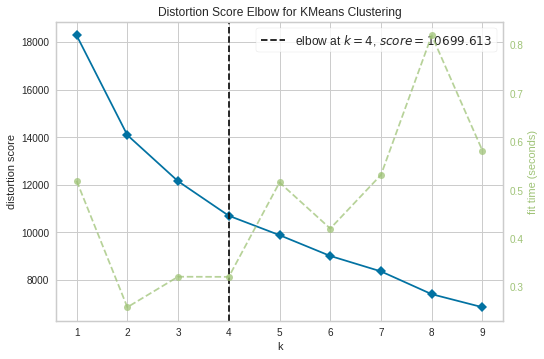

In [ ]:
# K-means
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=123)
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(clus_data)
visualizer.show()

In [ ]:
kmeans = KMeans(n_clusters=4, random_state = 123).fit(clus_data)
X_train['cluster'] = kmeans.labels_

X_train['cluster'].value_counts().sort_index()

0    1694
1    2256
2    3050
3    2643
Name: cluster, dtype: int64

In [ ]:
rfm_cv = X_train.groupby('cluster').agg({
    'Recency' : ['mean', 'std'],
    'Frequency' : ['mean', 'std'],
    'Monetary' : ['mean', 'std']
})
rfm_cv

Recency                Frequency                  Monetary  \
               mean          std        mean         std          mean   
cluster                                                                  
0        766.883117  1290.848486  162.616293  194.820420  3.603760e+06   
1        616.591755  1097.712681  208.006649  231.889693  4.238489e+06   
2        828.718361  1329.981849  154.385574  205.351384  3.873683e+06   
3        816.959894  1312.462139  150.618994  195.314887  3.485712e+06   

                       
                  std  
cluster                
0        7.337770e+06  
1        1.189545e+07  
2        1.368735e+07  
3        8.241063e+06

In [ ]:
rfm_cv['r_cv'] = rfm_cv.iloc[:, 1]/rfm_cv.iloc[:, 0]
rfm_cv['f_cv'] = rfm_cv.iloc[:, 3]/rfm_cv.iloc[:, 2]
rfm_cv['m_cv'] = rfm_cv.iloc[:, 5]/rfm_cv.iloc[:, 4]
rfm_cv

Recency                Frequency                  Monetary  \
               mean          std        mean         std          mean   
cluster                                                                  
0        766.883117  1290.848486  162.616293  194.820420  3.603760e+06   
1        616.591755  1097.712681  208.006649  231.889693  4.238489e+06   
2        828.718361  1329.981849  154.385574  205.351384  3.873683e+06   
3        816.959894  1312.462139  150.618994  195.314887  3.485712e+06   

                           r_cv      f_cv      m_cv  
                  std                                
cluster                                              
0        7.337770e+06  1.683240  1.198038  2.036143  
1        1.189545e+07  1.780291  1.114819  2.806531  
2        1.368735e+07  1.604866  1.330120  3.533420  
3        8.241063e+06  1.606520  1.296748  2.364241

In [ ]:
w1 = min(rfm_cv.r_cv)/sum(rfm_cv.r_cv)
w2 = min(rfm_cv.f_cv)/sum(rfm_cv.f_cv)
w3 = min(rfm_cv.m_cv)/sum(rfm_cv.m_cv)
print(w1, w2, w3)

0.24043235223711093 0.22568437810556363 0.1895790908514462


In [ ]:
X_train['RFM'] = (w1*X_train['R'].astype(int) + w2*X_train['F'].astype(int) + w3*X_train['M'].astype(int))/5*100
X_valid['RFM'] = (w1*X_valid['R'].astype(int) + w2*X_valid['F'].astype(int) + w3*X_valid['M'].astype(int))/5*100
X_test['RFM'] = (w1*X_test['R'].astype(int) + w2*X_test['F'].astype(int) + w3*X_test['M'].astype(int))/5*100
X_train.RFM.describe()

count    9643.000000
mean       39.216984
std        15.571058
min        13.113916
25%        26.227833
50%        39.636709
75%        52.160706
max        65.569582
Name: RFM, dtype: float64

In [ ]:
X_train.columns

Index(['buy_std', '대대분류_Baby', '대대분류_Beauty', '대대분류_Culture',
       '대대분류_Electronic', '대대분류_Etc', '대대분류_Fashion', '대대분류_Food',
       '대대분류_Health', '대대분류_Home', '대대분류_Pet', '대대분류_Travel', 'RedDay',
       'TD_Midnight', 'TD_Daybreak', 'TD_Morning', 'TD_Midday', 'TD_Twilight',
       'lpay', 'Recency', 'Frequency', 'Monetary', 'R', 'F', 'M',
       'ma_fem_dv_남성', 'ma_fem_dv_여성', 'ages_20대', 'ages_30대', 'ages_40대',
       'ages_50대', 'ages_60대 이상', 'NSI_beta', 'ILU_beta', 'cluster', 'RFM'],
      dtype='object')

In [ ]:
X_train.drop(['Recency', 'Frequency', 'Monetary', 'cluster', 'R', 'F', 'M'], axis=1, inplace=True)
X_valid.drop(['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M'], axis=1, inplace=True)
X_test.drop(['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M'], axis=1, inplace=True)

In [ ]:
print(X_train.columns)
print("\n")
print(X_valid.columns)
print("\n")
print(X_test.columns)

Index(['buy_std', '대대분류_Baby', '대대분류_Beauty', '대대분류_Culture',
       '대대분류_Electronic', '대대분류_Etc', '대대분류_Fashion', '대대분류_Food',
       '대대분류_Health', '대대분류_Home', '대대분류_Pet', '대대분류_Travel', 'RedDay',
       'TD_Midnight', 'TD_Daybreak', 'TD_Morning', 'TD_Midday', 'TD_Twilight',
       'lpay', 'ma_fem_dv_남성', 'ma_fem_dv_여성', 'ages_20대', 'ages_30대',
       'ages_40대', 'ages_50대', 'ages_60대 이상', 'NSI_beta', 'ILU_beta', 'RFM'],
      dtype='object')


Index(['buy_std', '대대분류_Baby', '대대분류_Beauty', '대대분류_Culture',
       '대대분류_Electronic', '대대분류_Etc', '대대분류_Fashion', '대대분류_Food',
       '대대분류_Health', '대대분류_Home', '대대분류_Pet', '대대분류_Travel', 'RedDay',
       'TD_Midnight', 'TD_Daybreak', 'TD_Morning', 'TD_Midday', 'TD_Twilight',
       'lpay', 'ma_fem_dv_남성', 'ma_fem_dv_여성', 'ages_20대', 'ages_30대',
       'ages_40대', 'ages_50대', 'ages_60대 이상', 'NSI_beta', 'ILU_beta', 'RFM'],
      dtype='object')


Index(['buy_std', '대대분류_Baby', '대대분류_Beauty', '대대분류_Culture',
       '대대분류_Electronic', '대대분류_

# 변수 간 heatmap

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


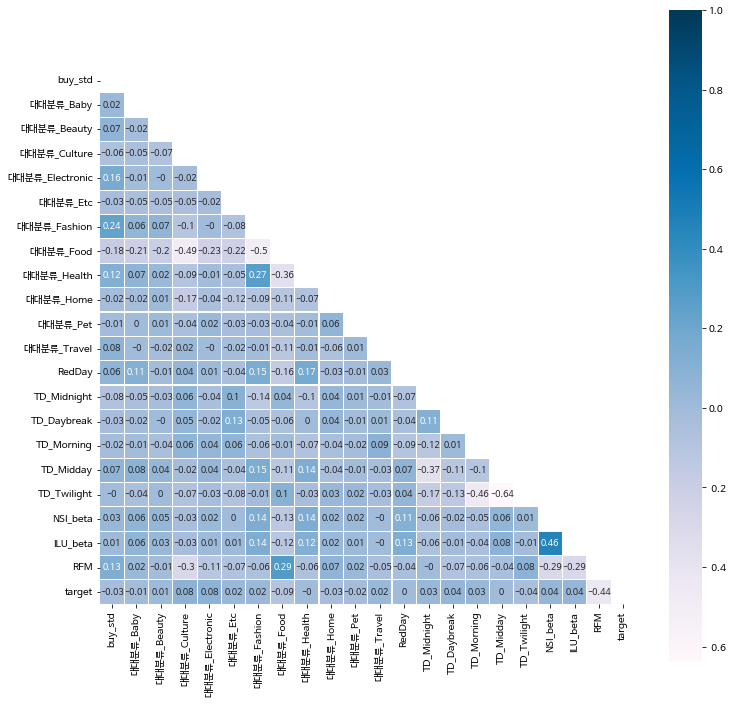

In [ ]:
import numpy as np
X_train.drop(X_train.columns[X_train.columns.str.contains("ages|ma|pay")], axis=1, inplace=True)

data = pd.concat([X_train, y_train], axis=1)

colormap = plt.cm.PuBu
upp_mat = np.triu(data.astype(float).corr()) # mask
plt.figure(figsize=(12, 12))
sns.heatmap(round(data.astype(float).corr(), 2), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, mask = upp_mat, annot_kws = {"size" : 9})

In [ ]:
# demo.to_csv(path+"전처리7/new_demo.csv", index=False)
# X_train.to_csv(path+"전처리7/X_train.csv", index=False)
# X_valid.to_csv(path+"전처리7/X_valid.csv", index=False)
# X_test.to_csv(path+"전처리7/X_test.csv", index=False)
# y_train.to_csv(path+"전처리7/y_train.csv", index=False)
# y_valid.to_csv(path+"전처리7/y_valid.csv", index=False)
# y_test.to_csv(path+"전처리7/y_test.csv", index=False)
# temp.to_csv(path+"전처리7/temp.csv", index=False)
# data.to_csv(path+"전처리7/data.csv", index=False) # X_train+y_train